In [91]:
import math
import numpy as np
import matplotlib.pyplot as plt

# Requires TensorFlow >=2.11 for the GroupNormalization layer.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

In [20]:
x,y = [], []
with open("bicycle.txt") as bicycle:
    for line in bicycle:
        row = line.split()
        x.append(float(row[0]))
        y.append(float(row[1]))

data = np.array(list(zip(x,y)))
print(data[500:510])

[[0.21965318 0.94470046]
 [0.22254335 0.94470046]
 [0.22543353 0.94470046]
 [0.2283237  0.94470046]
 [0.23121387 0.94470046]
 [0.23410405 0.94470046]
 [0.23699422 0.94470046]
 [0.23988439 0.94470046]
 [0.24277457 0.94470046]
 [0.24566474 0.94470046]]


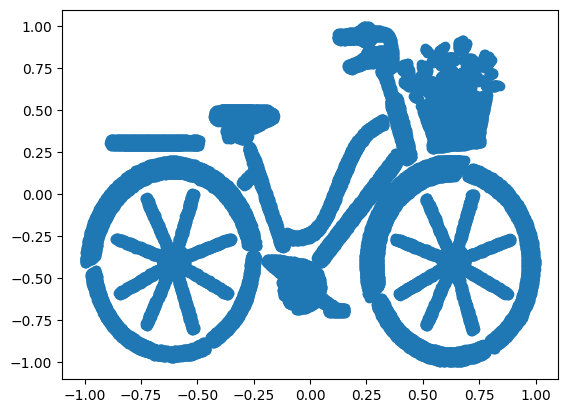

In [21]:
# 2-dimensional distribution of data - target distribution we'll try to approximate
# colorful image of dimensions 32x32x3 will be considered as one point of similar distribution. except 3072-dimensional
plt.scatter(x,y)

In [22]:
# Let's try to add noise to each point

In [23]:
n_steps = 1000 # number of noiseadding steps

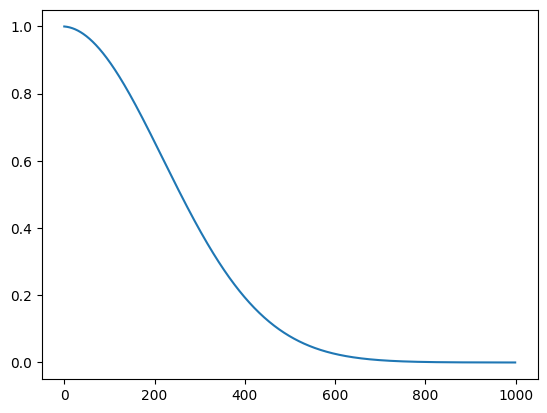

In [54]:
# parameters
betas = tf.linspace(0.0001,0.02,n_steps)
alphas = 1 - betas
alpha_prods = tf.math.cumprod(alphas)
plt.plot(alpha_prods)

In [25]:
# This method falls down to zero too quickly. We need another one
# turns out if we swap the range to 

In [83]:
steps = (tf.range(0,n_steps,dtype=tf.float32)-n_steps/2) / 100
betas = tf.exp(steps)/(1+tf.exp(steps))
betas = betas*0.0101188381035 # value chosen by trial and error :)

tf.Tensor(0.49750337, shape=(), dtype=float32)


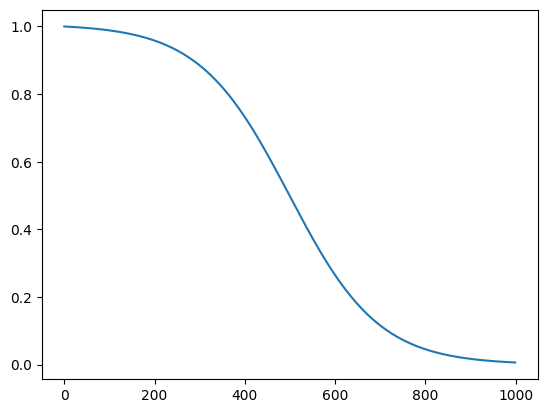

In [84]:
alphas = 1-betas
alpha_prods = tf.math.cumprod(alphas)
print(alpha_prods[500])
plt.plot(alpha_prods)

In [28]:
# adding noise to the data

In [102]:
I = tf.eye(2)
N = len(data)

In [106]:
noise = np.random.multivariate_normal((0,0),I,N*n_steps).reshape((n_steps,N,2)) * tf.reshape((1-alpha_prods),(n_steps,1,1))

In [108]:
data_means = data*tf.reshape(tf.sqrt(alpha_prods),(1000,1,1))

In [125]:
iterations = noise+data_means
iterations = tf.reshape(iterations,iterations.shape[:2] + [1] + iterations.shape[2])

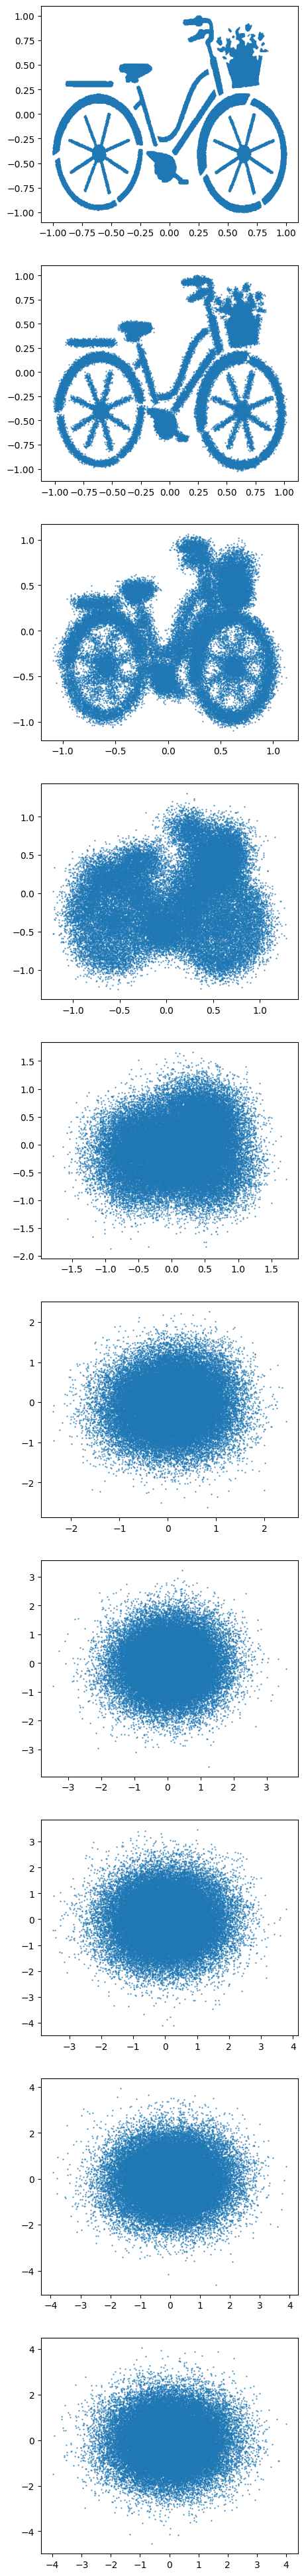

In [127]:
figure, axis = plt.subplots(10,figsize=(5,50))

for i in range(10):
    axis[i].scatter(iterations[i*100,:,:,0],iterations[i*100,:,:,1],marker=".",s=1)

plt.show()

In [163]:
class LearnableSinusoidalEmbedding(layers.Layer):
    def __init__(self,d=25,n=10000):  
        super(LearnableSinusoidalEmbedding, self).__init__()
        self.d = d
        self.denominator = tf.cast(tf.math.pow(n,tf.range(d)/d),tf.float32)
        self.dense1 = layers.Dense(128,input_shape=(2*d,),activation="relu")
        self.dense2 = layers.Dense(128)

    def call(self, k):
        k = tf.cast(k, tf.float32)
        # values of cosine and sine can be permuted however we want as we're feeding them to dense layers
        input = (tf.concat([tf.sin(k/self.denominator),tf.cos(k/self.denominator)],0))
        input = tf.reshape(tf.convert_to_tensor(input),(1,-1))
        output1 = self.dense1(input)
        return self.dense2(output1)

In [164]:
lse = LearnableSinusoidalEmbedding(25)

In [166]:
lse(1).shape

tensorflow.python.framework.ops.EagerTensor

In [131]:
class ConditionalDenseLayer(layers.Layer):
    def __init__(self,d=25,n=10000,relu=True):  
        super(ConditionalDenseLayer, self).__init__()
        self.lse = LearnableSinusoidalEmbedding(d,n)
        self.dense = layers.Dense(128,input_shape=(2,))
        self.relu = relu

    def call(self, point,t):
        tensor = self.lse(t) + self.dense(point)
        if self.relu:
            return tf.keras.activations.relu(tensor)
        else:
            return tensor

In [132]:
cdl = ConditionalDenseLayer()

In [138]:
cdl(iterations[0,0],2).shape

TensorShape([1, 128])

In [171]:
class DiffusionModel(layers.Layer):
    def __init__(self,d=25,n=10000):  
        super(DiffusionModel, self).__init__()
        self.cdl1 = ConditionalDenseLayer(d,n)
        self.cdl2 = ConditionalDenseLayer(d,n)
        self.cdl3 = ConditionalDenseLayer(d,n)
        self.cdl4 = ConditionalDenseLayer(d,n,relu=False)

    def call(self, point,t):
        data = self.cdl1(point,t)
        data = self.cdl2(data,t)
        data = self.cdl3(data,t)
        return self.cdl4(data,t)
    

In [172]:
diffusion_model = DiffusionModel()

In [183]:
diffusion_model(iterations[0,:64],2).shape

TensorShape([64, 1, 128])